# Convolutional network


In [1]:
import torch
import numpy as np
import torch.nn as nn
from visualizer import *
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform=transforms.Compose([
            transforms.Resize(size=18),
            transforms.CenterCrop(size=16),
            transforms.ToTensor()
        ])

In [3]:
train = datasets.ImageFolder(root='./dataset/dataset_train', transform=transform)
test = datasets.ImageFolder(root='./dataset/dataset_test', transform=transform)
rng = np.random.default_rng(seed=123401234)
num_classes = 4

train_loader = DataLoader(train, batch_size=len(train))
test_loader = DataLoader(test, batch_size=len(test))

train_set_img, train_set_labels = next(iter(train_loader))
test_set_img, test_set_labels = next(iter(test_loader))

train_set_img = torch.squeeze(train_set_img[:,0,:,:])
test_set_img = torch.squeeze(test_set_img[:,0,:,:])


# permute the arrays so we can visualize different classes with first 10 imgs
rand_idx_train = rng.permutation(len(train_set_img))
X_train = train_set_img[rand_idx_train]
Y_train = train_set_labels[rand_idx_train]

rand_idx_test = rng.permutation(len(test_set_img))
X_test = test_set_img[rand_idx_test]
Y_test = test_set_labels[rand_idx_test]


In [ ]:
"""
train = datasets.MNIST('./dataset', train=True, download=True,
                       transform=transform)
test = datasets.MNIST('./dataset', train=False,
                       transform=transform)

train_loader = DataLoader(train, batch_size=len(train))
test_loader = DataLoader(test, batch_size=len(test))

train_set_img, train_set_labels = next(iter(train_loader))
test_set_img, test_set_labels = next(iter(test_loader))

X_train = train_set_img
X_test = test_set_img
Y_train = train_set_labels
Y_test = test_set_labels
"""

Input shapes: X_train_input: torch.Size([1000, 16, 16]), X_test_input: torch.Size([200, 16, 16]),Y_train_input: torch.Size([1000]), Y_test_input: torch.Size([200])
number of samples with label 0 in train set: 250
number of samples with label 1 in train set: 250
number of samples with label 2 in train set: 250
number of samples with label 3 in train set: 250
number of samples with label 0 in test set: 50
number of samples with label 1 in test set: 50
number of samples with label 2 in test set: 50
number of samples with label 3 in test set: 50
first 10 img of train set:


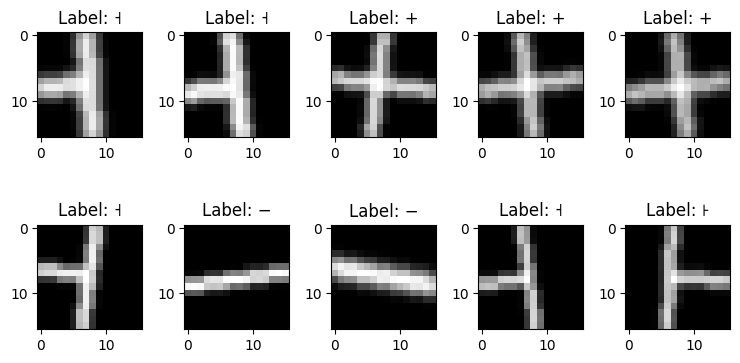

first 10 img of test set:


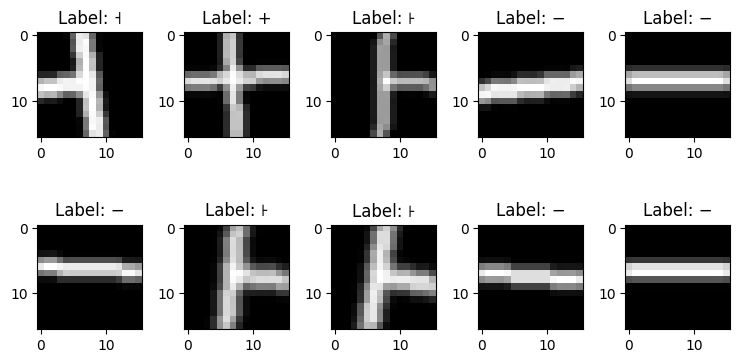

In [5]:
### Visualize some img

classes = [0,1,2,3]
num_classes = len(classes)

def count_occurrences(x,y, set):
    for label in range(len(classes)):
        occurrences = x[y == label].shape[0]
        print(f"number of samples with label {label} in {set} set: {occurrences}")

padding = 0
X_train_input = X_train
Y_train_input = Y_train
X_test_input = X_test
Y_test_input = Y_test

X_train_orig = np.copy(X_train_input.detach().numpy())
X_test_orig = np.copy(X_test_input.detach().numpy())
    
if padding > 0:
    print("WHY ARE U USING PADDING :(")

print(f"Input shapes: X_train_input: {X_train_input.shape}, X_test_input: {X_test_input.shape},"
            +f"Y_train_input: {Y_train_input.shape}, Y_test_input: {Y_test_input.shape}") 

count_occurrences(X_train_input,Y_train_input, "train")
count_occurrences(X_test_input,Y_test_input, "test")

print('first 10 img of train set:')
show_images(X_train_orig, Y_train_input)

print('first 10 img of test set:')
show_images(X_test_orig, Y_test_input)

## Model architecture for Convolutional network

In [6]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NeuralNet(nn.Module):
    """ ConvNet architecture, single convolutional layer """
    def __init__(self, num_classes):
        super(NeuralNet, self).__init__()
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=6,            
                kernel_size=5,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),    
        )   
        # output after (conv + pool): (6x6)*6 = 216
        self.out = nn.Linear(6 * 6 * 6, num_classes)

    def forward(self, x):
        output = self.conv(x)
        #output = torch.flatten(output)
        output = output.view(output.size(0), -1)
        output = self.out(output)
        # no softmax here, as this is part of nn.CrossEntropyoss()
        return output

In [7]:
#### LOSS, OPTIMIZER AND TRAIN LOOP ####

################
PRETRAINED = False
PATH = f"./model_checkpoints/ConvNet-single-layer-0_0reg-ep20"
learning_rate = 0.001
weight_decay = 0.0
################

input_size = 256
model = NeuralNet(num_classes)#.to(device)

if PRETRAINED:
    model.load_state_dict(torch.load(PATH))
    model.eval()
    epochs = 0
else:
    epochs = 20
    
print(model)

criterion = nn.CrossEntropyLoss()
feats_train = X_train_input[:,None,:,:]
feats_test = X_test_input[:,None,:,:]
labels_train = Y_train_input
labels_test = Y_test_input

num_train = len(feats_train)
#assert num_train == 1000
batch_size = 50
num_batches = num_train//batch_size


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc = acc + 1
    acc = acc / len(labels)
    return acc

def gen_batches(num_samples, num_batches):
    assert batch_size * num_batches == len(feats_train)
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, batch_size))
    return perm_ind

def print_acc(epoch, save_checkpoints=False):
    with torch.no_grad():
        if not PRETRAINED and save_checkpoints:
            torch.save(model.state_dict(), f"./model_checkpoints/ConvNet-new-single-layer-0_0reg-ep{epoch}")
        predictions_train = model(feats_train[:100])
        predictions_test = model(feats_test[:100])
        cost_approx_train = criterion(predictions_train, labels_train[:100])
        cost_approx_test = criterion(predictions_test, labels_test[:100])

        acc_approx_train = accuracy(labels_train[:100], predictions_train)
        acc_approx_test = accuracy(labels_test[:100], predictions_test)
        print("Epoch {:5d} | Approx Cost (train): {:0.7f} | Approx Cost (val): {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f}"
        "".format(epoch, cost_approx_train, cost_approx_test, acc_approx_train, acc_approx_test))
    return predictions_train, predictions_test


for ep in range(epochs):
    batch_ind = gen_batches(num_train, num_batches)
    _, _ = print_acc(epoch=ep)
    
    for it in range(num_batches):
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]

        # Forward pass
        outputs = model(feats_train_batch)
        loss = criterion(outputs, labels_train_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

pred_train_final, pred_test_final = print_acc(epoch=epochs)


NeuralNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=216, out_features=4, bias=True)
)
Epoch     0 | Approx Cost (train): 1.3737998 | Approx Cost (val): 1.3838731 | Acc train: 0.5400000 | Acc val: 0.4500000
Epoch     1 | Approx Cost (train): 1.1933413 | Approx Cost (val): 1.1940863 | Acc train: 0.7600000 | Acc val: 0.7100000
Epoch     2 | Approx Cost (train): 0.8784266 | Approx Cost (val): 0.8979222 | Acc train: 1.0000000 | Acc val: 0.9800000
Epoch     3 | Approx Cost (train): 0.5450072 | Approx Cost (val): 0.5841236 | Acc train: 1.0000000 | Acc val: 1.0000000
Epoch     4 | Approx Cost (train): 0.3367674 | Approx Cost (val): 0.3722766 | Acc train: 1.0000000 | Acc val: 0.9900000
Epoch     5 | Approx Cost (train): 0.2147244 | Approx Cost (val): 0.2450163 | Acc train: 1.0000000 | Acc val: 1.0000000
Epoch     6 | Approx Cos

## Let's break stuff

In [8]:
#### ADVERSARIAL ATTACKS ####

def FGSM(loss, eps, feats, labels, weights):
    delta = torch.zeros_like(feats, requires_grad=True)
    loss = criterion(model(feats + delta), labels)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def PGD(model, feats, labels, epsilon=0.1, alpha=0.01, num_iter=10, randomize=False, positive=False):
    if randomize:
        delta = torch.rand_like(feats, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        loss = criterion(model(feats + delta), labels)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        if positive:
            delta.data = torch.where((delta+feats)<0,-feats,delta)
        delta.grad.zero_()
    return delta.detach()

Benign accuracy: 1.0
Adv accuracy: 0.54


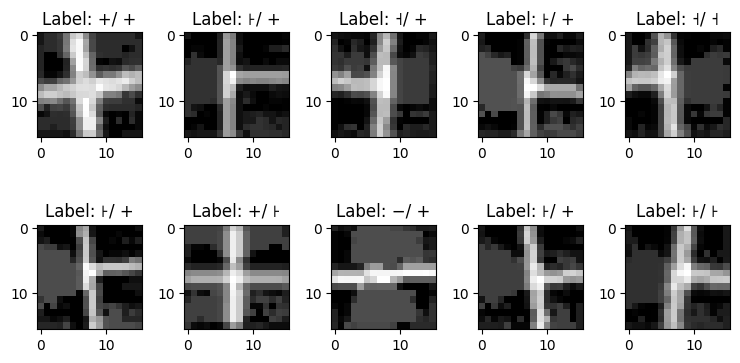

In [9]:
perturbed_X_train = PGD(model, feats=feats_train[:100], labels=labels_train[:100], epsilon=0.1, alpha=0.01, 
                  num_iter=10, randomize=False, positive=False)

print(f'Benign accuracy: {accuracy(labels_train[:100], model(feats_train[:100]))}')
pred_adv = model(feats_train[:100] + perturbed_X_train[:100])
print(f'Adv accuracy: {accuracy(labels_train[:100], pred_adv)}')

# visualize the attack patterns
perturbed_X_orig = torch.reshape(perturbed_X_train, (100,16,16)).detach().numpy() 
perturbed_img = X_train_orig[:100] + perturbed_X_orig[:100]
show_images_pred(X=perturbed_img[10:], Y=labels_train[10:], pred=pred_adv.detach().numpy()[10:])

In [ ]:
# here we can also check transferability by loading perturbations from other models

"""
path = './perturbations/perturbations-ConvNet-no_reg-ep20-PGD0_1-100_samples.npy'
perturbed_X_orig = np.load(path)
perturbed_X_train = torch.reshape(torch.from_numpy(perturbed_X_orig).float(), (100,1,16,16))

print(f'Benign accuracy: {accuracy(labels_train[:100], model(feats_train[:100]))}')
pred_adv = model(feats_train[:100]+perturbed_X_train[:100])
print(f'Adv accuracy: {accuracy(labels_train[:100], pred_adv)}')

# visualize the attack patterns
perturbed_img = X_train_orig[:100] + perturbed_X_orig[:100]
show_images_pred(X=perturbed_img[10:], Y=labels_train[10:], pred=pred_adv.detach().numpy()[10:])
"""